In [122]:
#load and initialize the data
import os
import scipy.misc
import numpy as np
import scipy.io
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from __future__ import print_function

load_path = "./dataset/Dataset/"
train_target = np.empty([150*10, 3, 100, 100])
train_label = np.empty([150*10,])
test_target = np.empty([50*10, 3, 100, 100])
test_label = np.empty([50*10,])
for i in range(0,10):
    lst = os.listdir(load_path+str(i)+"/")
    for j in range(0, 150):
        target_pic1 = scipy.misc.imread(load_path+str(i)+"/"+lst[j])/180
        target_pic = scipy.misc.imresize(target_pic1, (100,100,3))
        train_target[i*150+j] = (np.transpose(target_pic, (2, 0, 1)))
        train_label[i*150+j] = i
    
    for j in range(150, 200):
        target_pic1 = scipy.misc.imread(load_path+str(i)+"/"+lst[j])/180
        target_pic = scipy.misc.imresize(target_pic1, (100,100,3))
        test_target[i*50+j - 150] = (np.transpose(target_pic, (2, 0, 1)))
        test_label[i*50+j - 150] = i

In [123]:
#build the model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 6)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 5, padding = 4)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 3, padding = 4)
        self.drop3 = nn.Dropout2d()
        self.bn3 = nn.BatchNorm2d(256)
        self.ada_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc= nn.Linear(256,10)
        
    def forward(self, x):
        # conv,maxpool,relu ->maxpool->conv,maxpool,bn,relu->
        #->maxpool,dropout,bn,relu->adapool->dropout,fc->softmax
        x = F.max_pool2d(self.conv1(x), 3, stride = 2)
        x = F.relu(x)
        x = F.max_pool2d(x, 3)
        x = F.max_pool2d(self.conv2(x), 3)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(self.conv3(x), 2)
        x = self.drop3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.ada_pool(x)
        x = x.view(x.size(0),-1)
        x = F.relu(x)
        x = F.dropout(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        #traint the model with nll loss, which is equals to entropy cross loss with log softmax in the end
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx%3 == 0 :
            print('train epoch: {} [{}/{}]\t Loss:{:.6f}'.format(
                epoch, batch_idx * len(data), 
                len(train_loader.dataset), loss.item()))
    print("\n")
    
def main():
    epoch = 50
    train_batch_size = 64
    test_batch_size = 50
    lr = 0.01
    model = Net()
    #adam optimizer
    optimizer = optim.Adam(model.parameters())

    
    target = torch.from_numpy(train_target).float()
    label = torch.from_numpy(train_label).long()
    dataset = torch.utils.data.TensorDataset(target, label)

    train_loader = torch.utils.data.DataLoader(dataset,
                                               batch_size = train_batch_size,
                                              shuffle = True)

    for i in range(1, epoch+1):
        train(model, train_loader, optimizer, i)

    ckpt = model.state_dict()
    torch.save(ckpt, "./ckpt.pth")
        
        

        
if __name__ == '__main__':
    main()
        

train epoch: 1 [0/1500]	 Loss:2.312238
train epoch: 1 [192/1500]	 Loss:2.318260
train epoch: 1 [384/1500]	 Loss:2.316120
train epoch: 1 [576/1500]	 Loss:2.287737
train epoch: 1 [768/1500]	 Loss:2.255286
train epoch: 1 [960/1500]	 Loss:2.206152
train epoch: 1 [1152/1500]	 Loss:2.192310
train epoch: 1 [1344/1500]	 Loss:2.133809


train epoch: 2 [0/1500]	 Loss:2.122593
train epoch: 2 [192/1500]	 Loss:2.074633
train epoch: 2 [384/1500]	 Loss:2.014377
train epoch: 2 [576/1500]	 Loss:1.991700
train epoch: 2 [768/1500]	 Loss:1.937070
train epoch: 2 [960/1500]	 Loss:1.894846
train epoch: 2 [1152/1500]	 Loss:1.908342
train epoch: 2 [1344/1500]	 Loss:1.817746


train epoch: 3 [0/1500]	 Loss:1.770375
train epoch: 3 [192/1500]	 Loss:1.800799
train epoch: 3 [384/1500]	 Loss:1.679759
train epoch: 3 [576/1500]	 Loss:1.721899
train epoch: 3 [768/1500]	 Loss:1.610020
train epoch: 3 [960/1500]	 Loss:1.597124
train epoch: 3 [1152/1500]	 Loss:1.513050
train epoch: 3 [1344/1500]	 Loss:1.457693


train epoc

train epoch: 25 [768/1500]	 Loss:0.016153
train epoch: 25 [960/1500]	 Loss:0.015837
train epoch: 25 [1152/1500]	 Loss:0.015274
train epoch: 25 [1344/1500]	 Loss:0.011951


train epoch: 26 [0/1500]	 Loss:0.020779
train epoch: 26 [192/1500]	 Loss:0.023187
train epoch: 26 [384/1500]	 Loss:0.017522
train epoch: 26 [576/1500]	 Loss:0.013804
train epoch: 26 [768/1500]	 Loss:0.021158
train epoch: 26 [960/1500]	 Loss:0.014042
train epoch: 26 [1152/1500]	 Loss:0.020465
train epoch: 26 [1344/1500]	 Loss:0.015281


train epoch: 27 [0/1500]	 Loss:0.010430
train epoch: 27 [192/1500]	 Loss:0.011694
train epoch: 27 [384/1500]	 Loss:0.014115
train epoch: 27 [576/1500]	 Loss:0.015562
train epoch: 27 [768/1500]	 Loss:0.014465
train epoch: 27 [960/1500]	 Loss:0.013229
train epoch: 27 [1152/1500]	 Loss:0.011618
train epoch: 27 [1344/1500]	 Loss:0.012813


train epoch: 28 [0/1500]	 Loss:0.014778
train epoch: 28 [192/1500]	 Loss:0.015664
train epoch: 28 [384/1500]	 Loss:0.012896
train epoch: 28 [576/1500]	 

train epoch: 49 [1152/1500]	 Loss:0.016923
train epoch: 49 [1344/1500]	 Loss:0.009207


train epoch: 50 [0/1500]	 Loss:0.007827
train epoch: 50 [192/1500]	 Loss:0.008229
train epoch: 50 [384/1500]	 Loss:0.006968
train epoch: 50 [576/1500]	 Loss:0.004151
train epoch: 50 [768/1500]	 Loss:0.005204
train epoch: 50 [960/1500]	 Loss:0.005252
train epoch: 50 [1152/1500]	 Loss:0.008456
train epoch: 50 [1344/1500]	 Loss:0.004918




In [149]:

model = Net()
ckpt = torch.load("./ckpt.pth")
model.load_state_dict(ckpt)

target = torch.from_numpy(test_target).float()
label  = torch.from_numpy(test_label).long()
dataset = torch.utils.data.TensorDataset(target, label)
test_loader = torch.utils.data.DataLoader(dataset, batch_size = 50, shuffle = True)

def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, label in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, label, size_average = False).item()
            pred = output.max(1, keepdim = True)[1]
            correct += pred.eq(label.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    print('Test set: average loss: {:.4f} and accuracy: {:.0f}%'.format(
                test_loss, 100 * correct / len(test_loader.dataset)))    

# ----------------------------------------------------------------------------
test(model, test_loader)

Test set: average loss: 0.0979 and accuracy: 99%


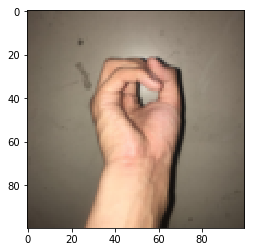


The finger number is: 0


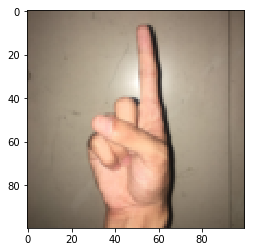


The finger number is: 1


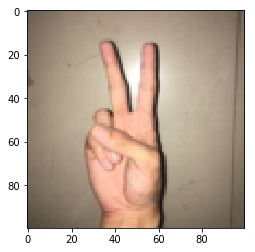


The finger number is: 2


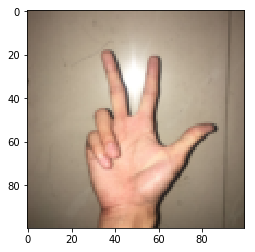


The finger number is: 3


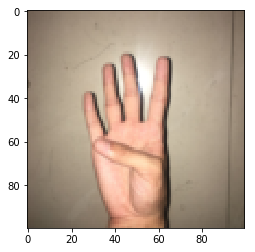


The finger number is: 4


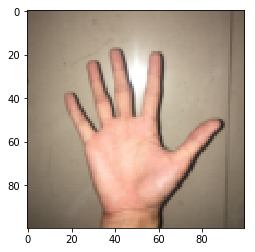


The finger number is: 5


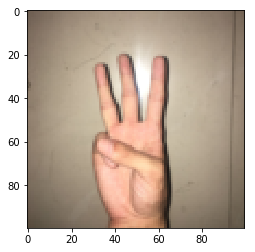


The finger number is: 6


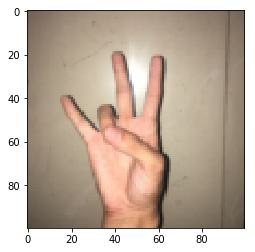


The finger number is: 4


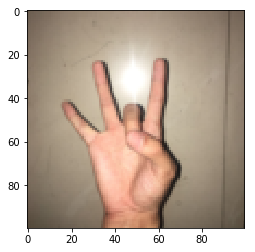


The finger number is: 8


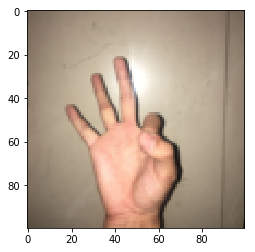


The finger number is: 9


In [148]:
model = Net()
ckpt = torch.load("./ckpt.pth")
model.load_state_dict(ckpt)
target_one3 = np.empty([10,3,100,100])
label_one = np.empty([10,])
img_show = []
for i in range(10):
    one_img_path = "./dataset/Dataset/"+str(i)+".jpg"
    target_one1 = scipy.misc.imread(one_img_path)
    target_one21 = scipy.misc.imresize(target_one1, (100,100,3))
    target_one2 = np.transpose(target_one21, [2,0,1])
    target_one3[i] = target_one2
    label_one[i] = i
    img_show.append(target_one21)

one_tar = torch.from_numpy(target_one3).float()
one_lab = torch.from_numpy(label_one).long()
dataset = torch.utils.data.TensorDataset(one_tar, one_lab)
one_test = torch.utils.data.DataLoader(dataset, batch_size = 1)

def test_one(model, data):
    model.eval()
    with torch.no_grad():
        q = 0
        for one_data, one_label in data:
            output = model(one_data)
            pred = output.max(1, keepdim=True)[1]
            check_data = one_data.numpy()[0]
            check_data = np.transpose(check_data, [1,2,0])
            plt.imshow(img_show[q])
            plt.show()
            print("\nThe finger number is: "+str(int(pred)))
            q += 1
    

plt.imshow(target_one1)
test_one(model, one_test)
plt.show()